In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import warnings
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
warnings.filterwarnings('ignore')

# Data loading and overview

In [11]:
train_df = pd.read_csv("dev.csv")
test_df = pd.read_csv("compete.csv")

In [12]:
# Get categorical features
categorical_features = list(train_df.columns[train_df.dtypes == object].values)
print(f'Categorical features: {categorical_features}')

# Get numerical features
numerical_features = list(train_df.columns[train_df.dtypes != object].values[:-1])
print(f'Numerical features: {numerical_features}')

Categorical features: ['protocol_type', 'service', 'flag']
Numerical features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [13]:
cardinality = (train_df[categorical_features].nunique() / train_df[categorical_features].count())
print(f'Cardinality:\n\n{cardinality}')
to_drop = cardinality.index[cardinality > 0.5].values
for feat in to_drop:
    train_df = train_df.drop(feat, axis=1)
    categorical_features.remove(feat)
print(f'\nFeatures dropped: {to_drop}')

Cardinality:

protocol_type    0.000009
service          0.000191
flag             0.000032
dtype: float64

Features dropped: []


In [14]:
train_df = train_df.drop(['is_host_login', 'num_outbound_cmds'], axis=1);
test_df = test_df.drop(['is_host_login', 'num_outbound_cmds'], axis=1);

In [15]:
train_df = pd.get_dummies(train_df, columns=['protocol_type'])
test_df = pd.get_dummies(test_df, columns=['protocol_type'])

In [16]:
from sklearn import preprocessing

cat_cols = ['service', 'flag']
for col in cat_cols:
    if col in train_df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   


Features dropped: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_icmp']


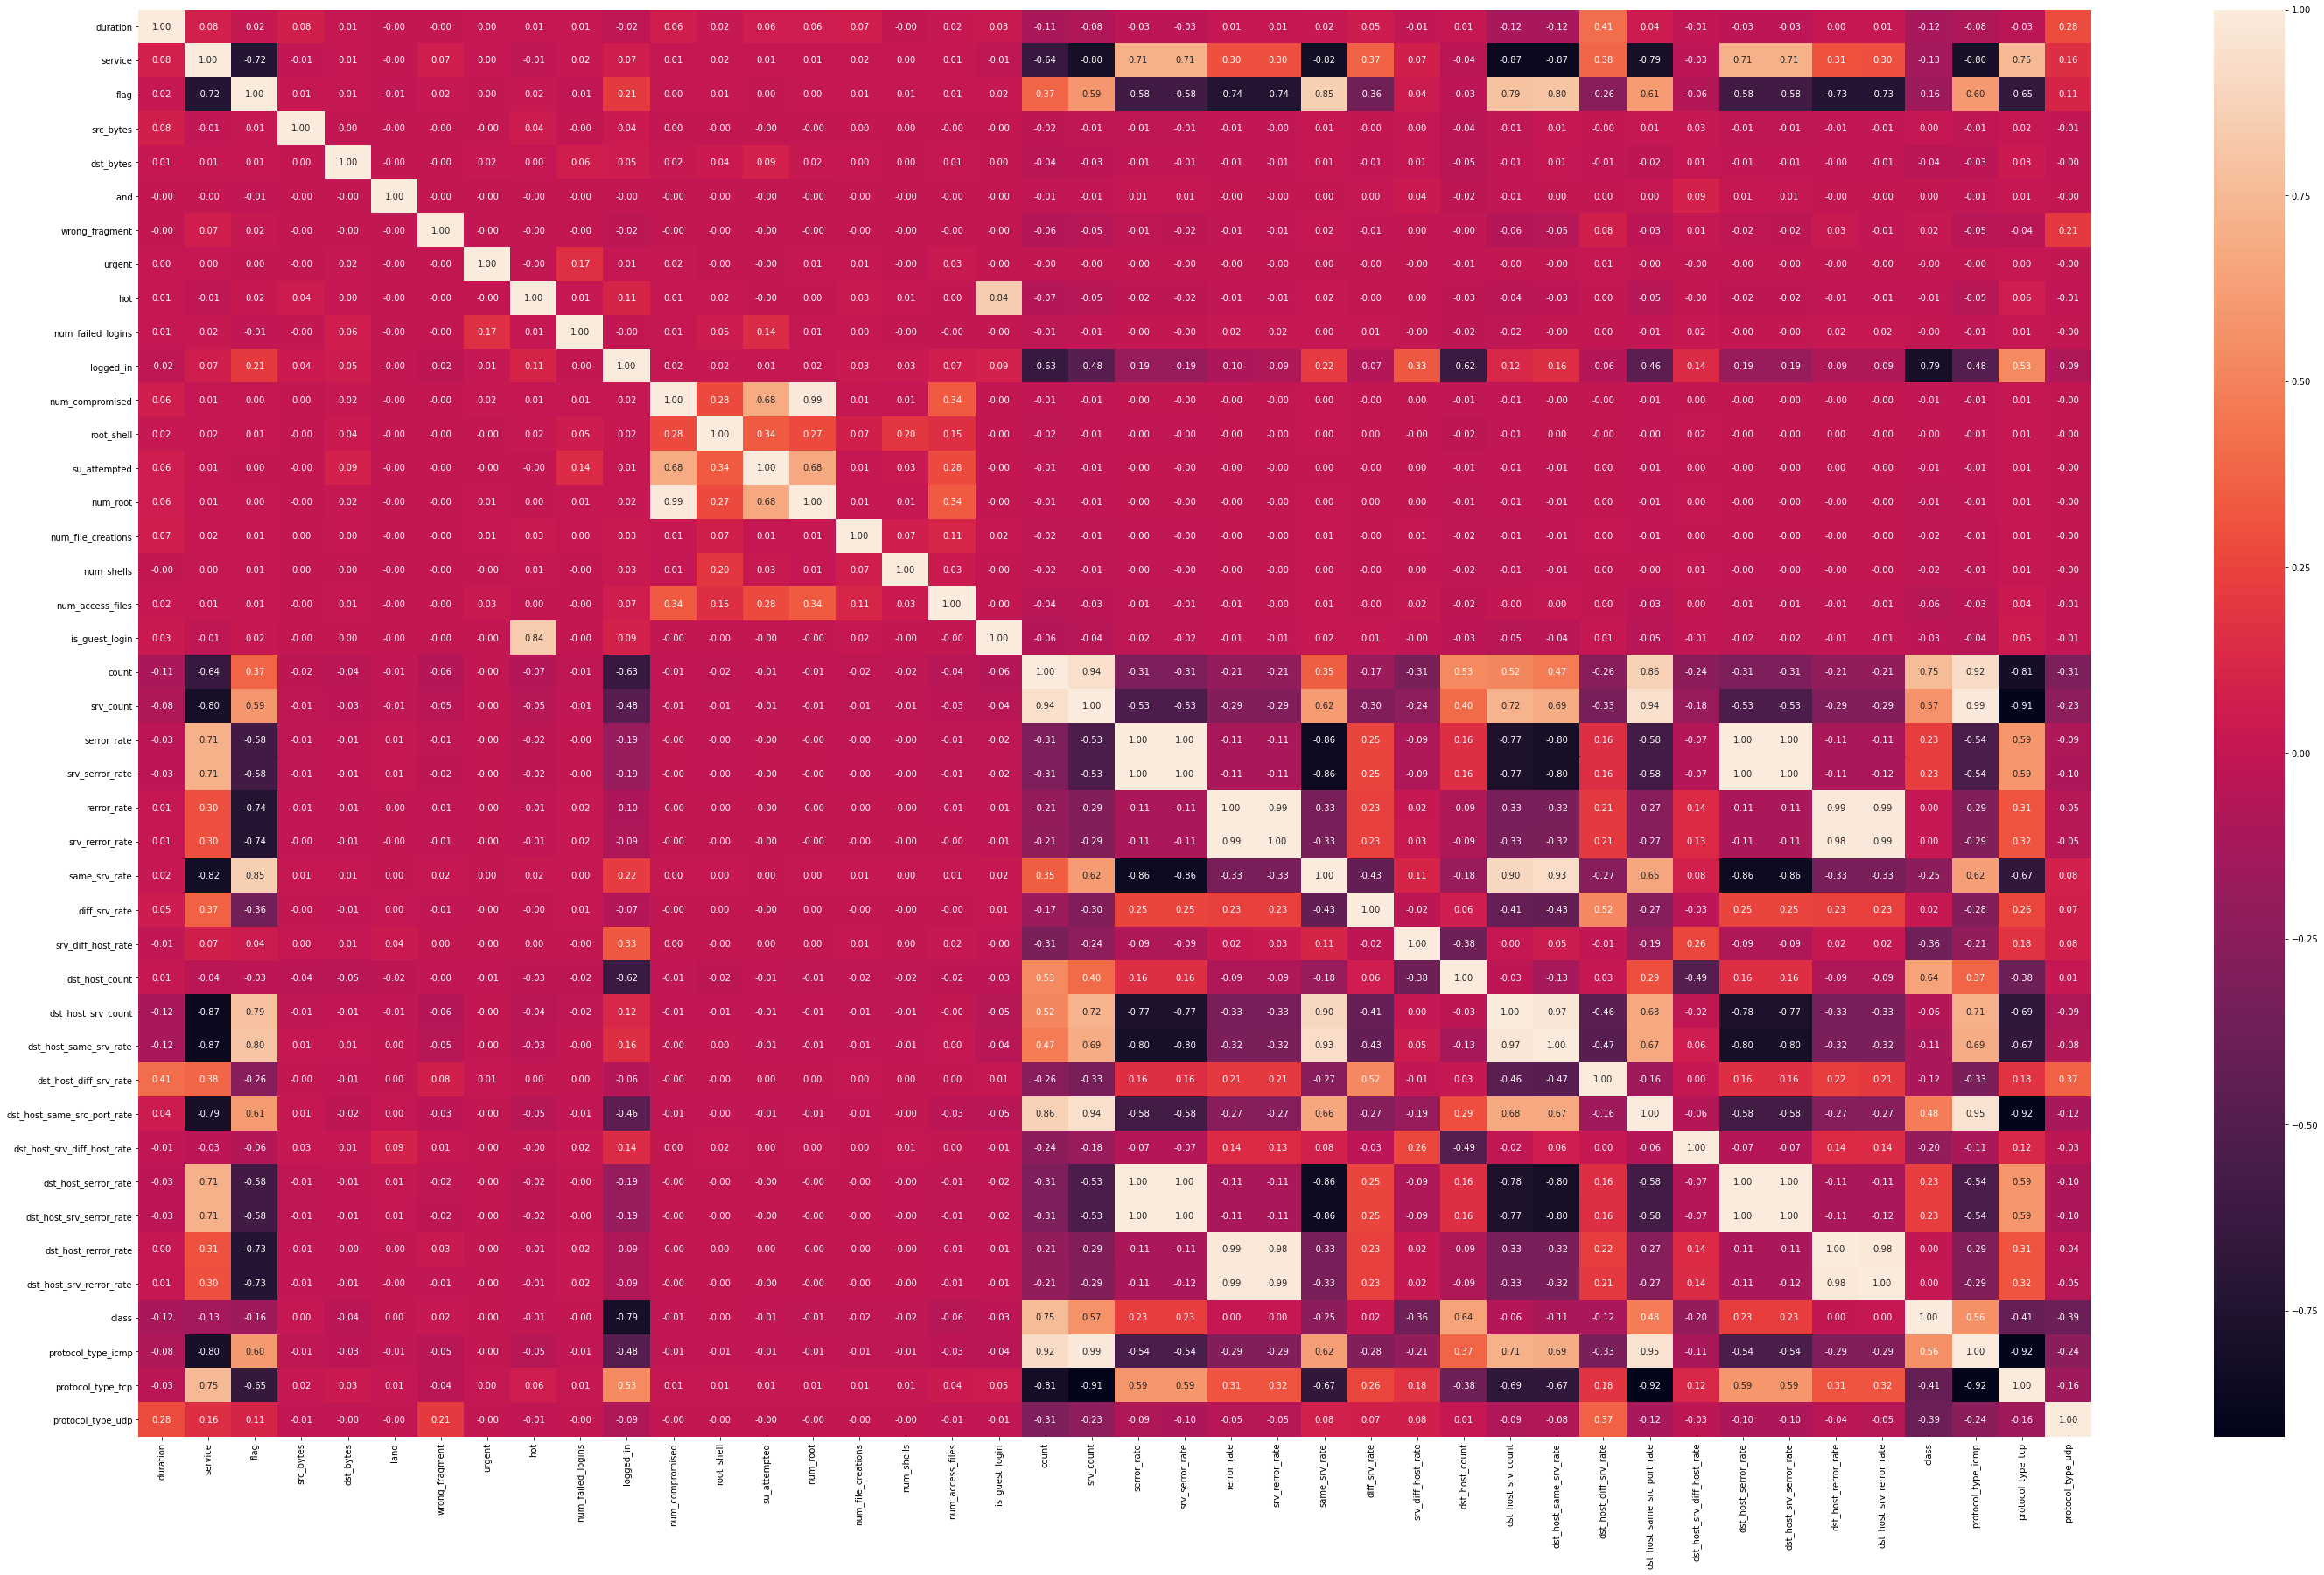

In [17]:
numerical_features = list(train_df.columns[train_df.dtypes != object].values[:-1])
categorical_features = list(train_df.columns[train_df.dtypes == object].values)

corr_table = train_df.corr()
triu = corr_table.where(np.triu(np.ones(corr_table.shape) ,k=1).astype(np.bool))
to_drop = [feat for feat in triu.columns if any(triu[feat] > 0.95)]

train_df = train_df.drop(to_drop, axis=1)

for feat in to_drop:
    if feat in categorical_features:
        categorical_features.remove(feat)
    else:
        numerical_features.remove(feat)

print(f'\nFeatures dropped: {to_drop}')
plt.figure(figsize=(50, 30))
_ = sns.heatmap(corr_table, annot=True, fmt='.2f')

In [ ]:
y_train.value_counts()

In [20]:
from sklearn.model_selection import train_test_split

X = train_df.drop('class', axis=1)
y = train_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### RandomForest classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_test = clf_rf.predict_proba(X_test)
y_pred_test_hat = clf_rf.predict(X_test)
print('Test set results:')
display(pd.DataFrame(classification_report(y_test, y_pred_test_hat, output_dict=True)).transpose())

Test set results:


,precision,recall,f1-score,support
0,0.999182,0.999759,0.999470,20766.000000
1,0.999940,0.999795,0.999867,82979.000000
accuracy,0.999788,0.999788,0.999788,0.999788
macro avg,0.999561,0.999777,0.999669,103745.000000
weighted avg,0.999788,0.999788,0.999788,103745.000000


#### Roc Auc Score

In [22]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred_test[:, 1])
roc_value

0.9999996483168363

#### Confusion Matrix

Confusion matrix:
 [[20761     5]
 [   17 82962]]


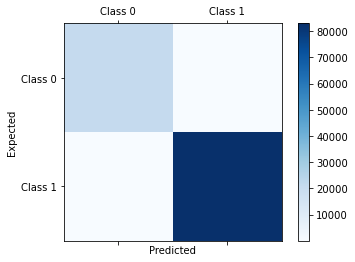

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test_hat)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

---

### XGBOOST Classifier

In [24]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

xgb = XGBClassifier(n_estimators=100, verbosity = 0)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 99.98


---

### LightGBM Classifier

In [25]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)

acc_lgm = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print("LightGBM's prediction accuracy is: %3.2f" % (acc_lgm))

LightGBM's prediction accuracy is: 99.98


### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0).fit(X_train, y_train)
preds_proba = clf_log.predict_proba(X_test)

preds_regression = clf_log.predict(X_test)

clf_log.score(X_test, y_test)

0.9838257265410382

Confusion matrix:
 [[20516   250]
 [ 1428 81551]]


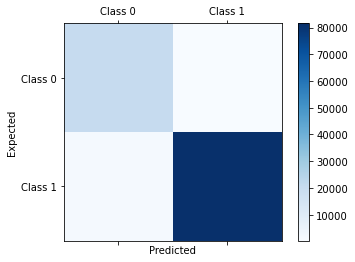

In [27]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=preds_regression)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

* Fitting the 3 models 

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# logistic regression
model1 = LogisticRegression()
# knn
model2 = RandomForestClassifier(random_state=42, n_jobs=-1)

model3 = KNeighborsClassifier(n_neighbors = 30)

# fit model
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)
pred_prob3 = model3.predict_proba(X_test)

Confusion matrix:
 [[20731    35]
 [   64 82915]]


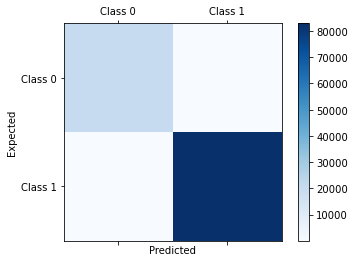

In [29]:
from sklearn.neighbors import KNeighborsClassifier

model3 = KNeighborsClassifier(n_neighbors = 5)
model3.fit(X_train, y_train)
p = model3.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=p)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Confusion matrix:
 [[20731    35]
 [   64 82915]]


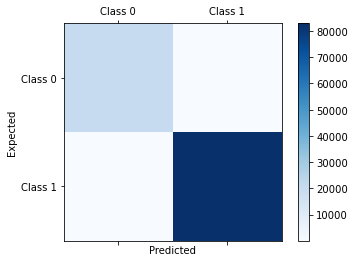

In [30]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=p)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

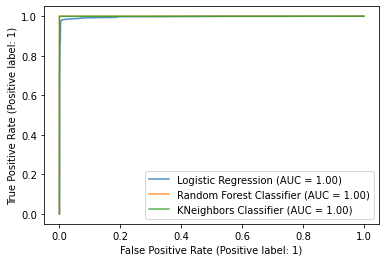

In [31]:
from sklearn import datasets, metrics, model_selection, svm

ax = plt.gca()
metrics.plot_roc_curve(clf_log, X_test, y_test, ax=ax, alpha=0.8, name="Logistic Regression")
metrics.plot_roc_curve(clf_rf, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest Classifier")
metrics.plot_roc_curve(model3, X_test, y_test, ax=ax, alpha=0.8, name="KNeighbors Classifier")
plt.show()

In [32]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [34]:
# plot(p_fpr, p_tpr)
# plt.show()

In [35]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1, auc_score2)

0.9966970311883436 0.9999996483168363


In [36]:
from sklearn.model_selection import cross_val_score

xgb_cv = XGBClassifier(n_estimators=100, verbosity = 0)
scores = cross_val_score(model2, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99950428 0.99979345 1.         0.99966952 0.99971083 0.99962821
 0.99983476 0.99975214 0.99983476 0.99975214]
Mean: 0.9997480067748998
Standard Deviation: 0.00012726006362415095


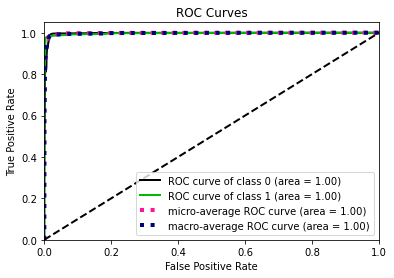

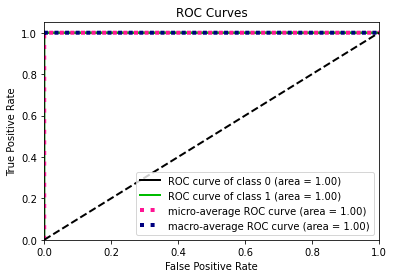

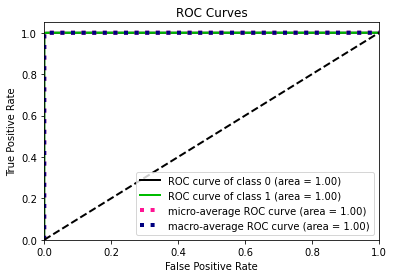

In [37]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, pred_prob1)
skplt.metrics.plot_roc_curve(y_test, pred_prob2)
skplt.metrics.plot_roc_curve(y_test, pred_prob3)
plt.show()

In [38]:
test_df = test_df.drop(to_drop, axis=1)
test_id = test_df.Id.values
test_df = test_df.drop("Id", axis=1)

In [39]:
preds = clf.predict(test_df)
preds_xgb = xgb.predict(test_df)
# preds_rf = clf_rf.predict(test_df) 

In [ ]:
submit = pd.DataFrame({'Id': test_id, 'class':preds})
submit.to_csv('RandomForest.csv', index=False)

In [ ]:
submit = pd.DataFrame({'Id': test_id, 'class':preds})
submit.to_csv('LGBM.csv', index=False)

In [ ]:
submit = pd.DataFrame({'Id': test_id, 'class':preds_xgb})
submit.to_csv('XGB.csv', index=False)